####  
# 1. Import libraries, and merge two data sets first
###  

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import statsmodels.formula.api as smf
from scipy.stats import t
from sklearn import preprocessing
from sklearn.metrics import silhouette_samples, silhouette_score
from sklearn.cluster import KMeans

from sklearn.decomposition import PCA
import seaborn as sns
from sklearn.linear_model import LogisticRegression
import statsmodels.api as sm
import scipy

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=UserWarning)

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\compat\pandas.py:49: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  data_klasses = (pandas.Series, pandas.DataFrame, pandas.Panel)


In [3]:
Categories = pd.read_csv('Categories.csv')

In [4]:
Income = pd.read_csv('Phoenix_Pop_Income.csv')

In [5]:
Categories.head()

,postal_code,Bakery,Bar,Breakfast,Burger,Chinese,Coffee,Deli,Diner,Donuts,...,Korean,Latin Food,Mexican,Other,Pizza,Sandwiches,Seafood,Thai,Vegetarian,Vietnamese
0,85001,0,0,0,0,0,1,1,0,0,...,0,0,1,1,1,0,0,0,0,0
1,85003,1,1,1,1,1,1,1,0,0,...,1,0,1,1,1,1,0,1,1,1
2,85004,1,1,1,1,1,1,1,1,1,...,0,1,1,1,1,1,0,1,1,1
3,85005,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
4,85006,1,1,1,1,1,1,1,0,0,...,0,1,1,1,1,1,0,0,1,1


In [6]:
Income.head()

,Unnamed: 0,GEO.id,GEO.id2,GEO.display-label,Households_Mean_income,Households_Median_income,ZIP_CODE,PO_NAME,STATE,Total_Pop
0,0,8600000US85003,85003,ZCTA5 85003,76877,47554,85003,Phoenix,AZ,7628
1,1,8600000US85004,85004,ZCTA5 85004,67493,33862,85001,Phoenix,AZ,5355
2,2,8600000US85004,85004,ZCTA5 85004,67493,33862,85002,Phoenix,AZ,5355
3,3,8600000US85004,85004,ZCTA5 85004,67493,33862,85004,Phoenix,AZ,5355
4,4,8600000US85004,85004,ZCTA5 85004,67493,33862,85030,Phoenix,AZ,5355


In [7]:
IP = Income[['Households_Mean_income','Households_Median_income','ZIP_CODE','Total_Pop']]

In [8]:
IP = IP.set_index('ZIP_CODE')
IP = IP.rename(columns={'Total_Pop':'Population', 'Households_Mean_income':'Mean_Income', 'Households_Median_income':'Median_Income'})

In [9]:
IP.head()

,Mean_Income,Median_Income,Population
ZIP_CODE,,,
85003,76877,47554,7628
85001,67493,33862,5355
85002,67493,33862,5355
85004,67493,33862,5355
85030,67493,33862,5355


In [10]:
df = pd.merge(IP, Categories, left_index=True, right_on=Categories['postal_code'],how='outer')

In [11]:
len(df)

95

### A little problem 

The two dataset contains different sets of zipcode. Phoneix supposes to have 93 zipcode, but each data set only contains around 70. Below are the zipcodes one doesn't have but the other has. 

If we do outer merge, there will be too many missing value. If we do inner merge, there will only be 50 samples. It seems we lose a lot of samples, but don't worry, it will be explained later.

In [12]:
for zipcode in IP.index:
    if zipcode not in list(Categories['postal_code']):
        print(zipcode)

85002
85010
85026
85039
85062
85072
85082
85011
85067
85061
85079
85068
85069
85080
85071
85063
85046
85078
85075
85065
85074
85066
85076
85070


In [13]:
for zipcode in list(Categories['postal_code']):
    if zipcode not in IP.index:
        print(zipcode)

85058
85209
85225
85234
85251
85253
85283
85284
85301
85302
85303
85304
85305
85306
85308
85310
85326
85331
85339
85355
85388


In [14]:
df = pd.merge(IP, Categories, left_index=True, right_on=Categories['postal_code'])

In [15]:
len(df)

50

If we are doing this, the samples are scarce

# 2. Feature Selection

#### There must be many correlated fetures, let's do PCA first.

(50, 30)

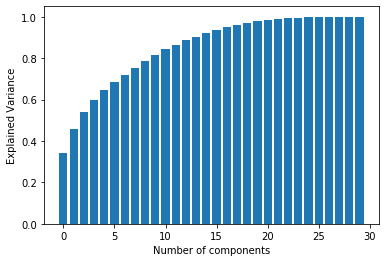

In [16]:
scaler = preprocessing.StandardScaler().fit(df)
df_S=scaler.transform(df)
pca = PCA(df_S.shape[1])
df_P=pca.fit_transform(df_S)
eigenvalues = pca.explained_variance_ratio_
#plot explained variance over the number of compinents
n=df_S.shape[1]
plt.bar(np.arange(n), eigenvalues[:n].cumsum())
plt.xlabel("Number of components")
plt.ylabel("Explained Variance")
plt.show()

In [17]:
for i in range(n):
    if list(eigenvalues[:i+1].cumsum())[i] >= 0.8:
        print('{} leading principal components are needed to cover 80%'.format(i+1))
        break

10 leading principal components are needed to cover 80%


#### 10 seems to be a good choice. The features are not too much, but contains enough infomation.

In [18]:
df_C = df_P[:,:10]

# 3. Deciding number of clusters 

In [19]:
range_n_clusters = [2, 3, 4, 5, 6, 7]
for n_clusters in range_n_clusters: #try different numbers of clusters
    km = KMeans(n_clusters=n_clusters, random_state=2498)
    cluster_labels = km.fit_predict(df_C)
    #report average Silhouette score
    silhouette_avg = silhouette_score(df_C, cluster_labels)
    print("For n_clusters ={},".format(n_clusters)+" the average silhouette_score is :{}".format(silhouette_avg))

For n_clusters =2, the average silhouette_score is :0.425890721343059
For n_clusters =3, the average silhouette_score is :0.20823390726560728
For n_clusters =4, the average silhouette_score is :0.21154119666668042
For n_clusters =5, the average silhouette_score is :0.20204626026713915
For n_clusters =6, the average silhouette_score is :0.20270733248321982
For n_clusters =7, the average silhouette_score is :0.19185038102464108


In [20]:
from scipy.spatial.distance import cdist, pdist
from sklearn.cluster import KMeans

def elbow(data,K):
#data is your input as numpy form
#K is a list of number of clusters you would like to show.
    # Run the KMeans model and save all the results for each number of clusters
    KM = [KMeans(n_clusters=k).fit(data) for k in K]
    
    # Save the centroids for each model with a increasing k
    centroids = [k.cluster_centers_ for k in KM]

    # For each k, get the distance between the data with each center. 
    D_k = [cdist(data, cent, 'euclidean') for cent in centroids]
    
    # But we only need the distance to the nearest centroid since we only calculate dist(x,ci) for its own cluster.
    globals()['dist'] = [np.min(D,axis=1) for D in D_k]
    
    # Calculate the Average SSE.
    avgWithinSS = [sum(d)/data.shape[0] for d in dist]
    
    
    # elbow curve
    fig = plt.figure()
    ax = fig.add_subplot(111)
    ax.plot(K, avgWithinSS, 'b*-')
    plt.grid(True)
    plt.xlabel('Number of clusters')
    plt.ylabel('Average within-cluster sum of squares')
    plt.title('Elbow for KMeans clustering')
    plt.show()
    
    
    # Total with-in sum of square plot. Another way to show the result.
    wcss = [sum(d**2) for d in dist]
    tss = sum(pdist(data)**2)/data.shape[0]
    bss = tss-wcss
    
    fig = plt.figure()
    ax = fig.add_subplot(111)
    ax.plot(K, bss/tss*100, 'b*-')
    plt.grid(True)
    plt.xlabel('Number of clusters')
    plt.ylabel('Percentage of variance explained')
    plt.title('Elbow for KMeans clustering')
    plt.show()

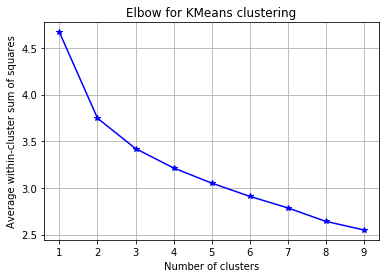

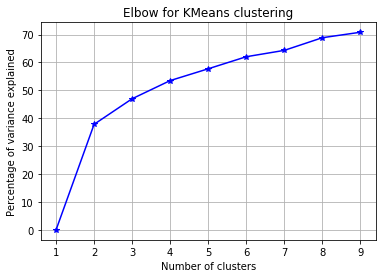

In [21]:
elbow(df_C, range(1,10))

#### It seems 2 clusters will be the optimal choice, let's visualize and see if it looks reasonable.

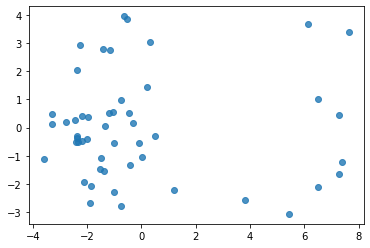

In [22]:
plt.plot(np.array(df_C[:,0]), np.array(df_C[:,1]),'o', alpha=0.8, label=True)

# 4. Clustering

#### The visualization seems just fine. So let's move on clustering them.

In [23]:
from sklearn.mixture import GaussianMixture 
gm=GaussianMixture(n_components=2,random_state=2498).fit(df_C)

In [24]:
labels = gm.predict(df_C)
labels

array([0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0,
       0, 0, 0, 1, 0, 0], dtype=int64)

(-4.152752422760355, 8.200621815563398, -3.419609886161545, 4.309809137420691)

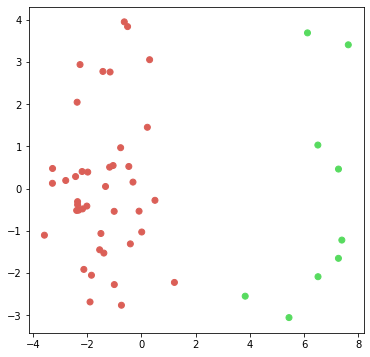

In [25]:
palette = np.array(sns.color_palette("hls", 3))
f = plt.figure(figsize=(6, 6))
ax = plt.subplot(aspect='equal')
sc = ax.scatter(df_C[:,0], df_C[:,1], c=palette[labels])
ax.axis('tight')

#### The clusters seem to be rather reasonable. So i'll skip other algorithms for now.

# 5. Check Each Clusters

In [26]:
df['label'] = labels

In [27]:
df = df.drop('key_0',axis=1)

In [28]:
df.head()

,Mean_Income,Median_Income,Population,postal_code,Bakery,Bar,Breakfast,Burger,Chinese,Coffee,...,Latin Food,Mexican,Other,Pizza,Sandwiches,Seafood,Thai,Vegetarian,Vietnamese,label
1,76877,47554,7628,85003,1,1,1,1,1,1,...,0,1,1,1,1,0,1,1,1,0
0,67493,33862,5355,85001,0,0,0,0,0,1,...,0,1,1,1,0,0,0,0,0,1
2,67493,33862,5355,85004,1,1,1,1,1,1,...,1,1,1,1,1,0,1,1,1,0
24,67493,33862,5355,85030,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
4,45802,32166,19716,85006,1,1,1,1,1,1,...,1,1,1,1,1,0,0,1,1,0


In [29]:
df.loc[df['label']==0]

,Mean_Income,Median_Income,Population,postal_code,Bakery,Bar,Breakfast,Burger,Chinese,Coffee,...,Latin Food,Mexican,Other,Pizza,Sandwiches,Seafood,Thai,Vegetarian,Vietnamese,label
1,76877,47554,7628,85003,1,1,1,1,1,1,...,0,1,1,1,1,0,1,1,1,0
2,67493,33862,5355,85004,1,1,1,1,1,1,...,1,1,1,1,1,0,1,1,1,0
4,45802,32166,19716,85006,1,1,1,1,1,1,...,1,1,1,1,1,0,0,1,1,0
5,56228,31396,10777,85007,1,1,1,1,1,1,...,1,1,1,1,1,0,0,0,0,0
6,45997,37696,44411,85008,1,1,1,1,1,1,...,1,1,1,1,1,1,0,0,1,0
47,45997,37696,44411,85073,0,1,1,1,1,1,...,0,1,1,1,1,0,0,0,0,0
7,38269,27506,33524,85009,0,1,1,1,1,0,...,0,1,1,1,1,1,0,0,1,0
8,94800,62672,5801,85012,1,1,1,1,1,1,...,1,1,1,1,1,0,1,1,0,0
9,78337,51889,17105,85013,1,1,1,1,1,1,...,1,1,1,1,1,0,1,1,0,0
10,65655,46390,22199,85014,1,1,1,1,1,1,...,1,1,1,1,1,0,0,1,0,0


In [30]:
df.loc[df['label']==1]

,Mean_Income,Median_Income,Population,postal_code,Bakery,Bar,Breakfast,Burger,Chinese,Coffee,...,Latin Food,Mexican,Other,Pizza,Sandwiches,Seafood,Thai,Vegetarian,Vietnamese,label
0,67493,33862,5355,85001,0,0,0,0,0,1,...,0,1,1,1,0,0,0,0,0,1
24,67493,33862,5355,85030,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
32,45997,37696,44411,85038,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
3,38269,27506,33524,85005,0,1,0,0,0,0,...,0,0,0,0,1,0,0,0,0,1
46,84153,55156,28528,85064,0,1,0,1,0,0,...,0,0,0,0,0,0,0,0,0,1
45,106266,60250,29805,85060,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
30,34957,24454,3206,85036,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,1
38,151792,134517,5450,85045,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
48,119861,104854,13514,85083,0,0,0,0,0,0,...,0,1,0,1,1,0,0,0,0,1


### Can't tell much about the difference. Let's get mean value over each cluster

In [31]:
pd.set_option('display.max_columns', None)
df.groupby('label').mean()

,Mean_Income,Median_Income,Population,postal_code,Bakery,Bar,Breakfast,Burger,Chinese,Coffee,Deli,Diner,Donuts,FastFood,French,Ice Cream,Indian,Italian,Japanese,Korean,Latin Food,Mexican,Other,Pizza,Sandwiches,Seafood,Thai,Vegetarian,Vietnamese
label,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
0,69680.634146,51846.000000,26029.219512,85030.902439,0.756098,1.000000,0.878049,1.000000,0.95122,0.951220,0.609756,0.707317,0.365854,0.951220,0.170732,0.902439,0.390244,0.609756,0.707317,0.02439,0.487805,1.000000,1.000000,1.000000,0.975610,0.170732,0.414634,0.365854,0.341463
1,79586.777778,56906.333333,18794.222222,85040.222222,0.000000,0.222222,0.000000,0.111111,0.00000,0.111111,0.333333,0.000000,0.000000,0.555556,0.000000,0.111111,0.000000,0.000000,0.000000,0.00000,0.000000,0.222222,0.111111,0.333333,0.222222,0.000000,0.000000,0.000000,0.000000


Now here is something insightful. It appears cluster 1 has more income but less population than cluster 0.  Besides all kinds of restaurants seems a lot less than that in cluster 0. And primary types of food are fast food, pizza, Burger and Deli or Coffee, Bar and Ice cream.

# 6. Use Geopandas to visualize it on shapefile

In [32]:
import geopandas as gpd

In [33]:
tzs=gpd.read_file('Arizona/Arizona_Zip_ShapeFile.shp')

In [34]:
tzs.head()

,OBJECTID,ZIP_CODE,PO_NAME,STATE,POPULATION,POP_SQMI,SQMI,Shape_Leng,Shape_Area,geometry
0,14,00014,West Pima County,AZ,-99,-99.00,1131.38,3.459478,0.280218,POLYGON ((-112.7276609998552 32.17310300030329...
1,15,00015,Coronado Ntl Forest,AZ,-99,-99.00,55.89,0.664997,0.013863,POLYGON ((-110.5879480001001 32.38510100011109...
2,114,00197,B M Goldwater A F Range,AZ,-99,-99.00,1807.48,4.181969,0.450314,POLYGON ((-112.2717269996013 33.11609199974606...
3,116,00199,Tonto National Forest,AZ,-99,-99.00,154.37,1.221308,0.038998,POLYGON ((-111.7094019998024 33.99976699964736...
4,27172,85003,Phoenix,AZ,11127,5401.46,2.06,0.139988,0.000518,POLYGON ((-112.0738663000897 33.48026539992833...


In [35]:
df['postal_code'] = df['postal_code'].astype(str)

In [36]:
df = df.set_index('postal_code')

In [37]:
labels = {ind: df.label[ind] for ind in df.index}

In [38]:
tzs['labels'] = tzs.ZIP_CODE.map(labels)

In [39]:
tzs.head(10)

,OBJECTID,ZIP_CODE,PO_NAME,STATE,POPULATION,POP_SQMI,SQMI,Shape_Leng,Shape_Area,geometry,labels
0,14,00014,West Pima County,AZ,-99,-99.00,1131.38,3.459478,0.280218,POLYGON ((-112.7276609998552 32.17310300030329...,NaN
1,15,00015,Coronado Ntl Forest,AZ,-99,-99.00,55.89,0.664997,0.013863,POLYGON ((-110.5879480001001 32.38510100011109...,NaN
2,114,00197,B M Goldwater A F Range,AZ,-99,-99.00,1807.48,4.181969,0.450314,POLYGON ((-112.2717269996013 33.11609199974606...,NaN
3,116,00199,Tonto National Forest,AZ,-99,-99.00,154.37,1.221308,0.038998,POLYGON ((-111.7094019998024 33.99976699964736...,NaN
4,27172,85003,Phoenix,AZ,11127,5401.46,2.06,0.139988,0.000518,POLYGON ((-112.0738663000897 33.48026539992833...,0.0
5,27173,85004,Phoenix,AZ,5508,2713.30,2.03,0.136446,0.000510,POLYGON ((-112.0650820002341 33.48020200042203...,0.0
6,27174,85006,Phoenix,AZ,27818,6937.16,4.01,0.128137,0.001007,"POLYGON ((-112.0301510000685 33.4513469998642,...",0.0
7,27175,85007,Phoenix,AZ,15170,3305.01,4.59,0.167848,0.001152,POLYGON ((-112.0913769996488 33.48047400037484...,0.0
8,27176,85008,Phoenix,AZ,61398,6164.46,9.96,0.255480,0.002501,POLYGON ((-111.9609549998733 33.48001599993847...,0.0
9,27177,85009,Phoenix,AZ,57490,4080.20,14.09,0.255050,0.003538,POLYGON ((-112.0999799997771 33.48060099993626...,0.0


In [40]:
gdf = tzs.dropna(how='any', axis=0)

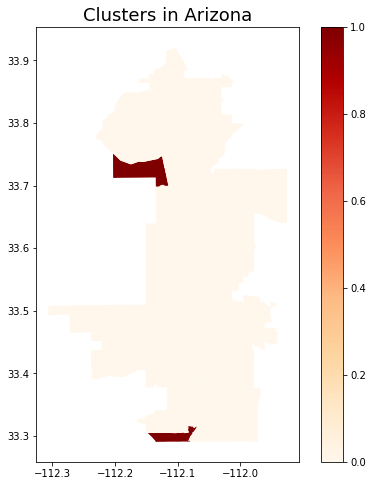

In [41]:
f, ax = plt.subplots(1, figsize=(8, 8))
ax.set_title("Clusters in Arizona", fontsize=18)
gdf.plot(axes=ax, column='labels', legend = True, cmap='OrRd')

#### The result is not optimistic. Let's find out why.

In [42]:
gdf.loc[gdf['labels']==1]

,OBJECTID,ZIP_CODE,PO_NAME,STATE,POPULATION,POP_SQMI,SQMI,Shape_Leng,Shape_Area,geometry,labels
37,27205,85045,Phoenix,AZ,8107,2105.71,3.85,0.206282,0.000964,POLYGON ((-112.0800164002367 33.29107880004665...,1.0
43,27211,85083,Phoenix,AZ,20235,2039.82,9.92,0.277995,0.002500,POLYGON ((-112.1148829999505 33.69979199960113...,1.0


In [43]:
for i ,c in enumerate(gdf['geometry']):
    print(type(c))
    break

<class 'shapely.geometry.polygon.Polygon'>


In [44]:
df.loc[df['label']==1]

,Mean_Income,Median_Income,Population,Bakery,Bar,Breakfast,Burger,Chinese,Coffee,Deli,Diner,Donuts,FastFood,French,Ice Cream,Indian,Italian,Japanese,Korean,Latin Food,Mexican,Other,Pizza,Sandwiches,Seafood,Thai,Vegetarian,Vietnamese,label
postal_code,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
85001,67493,33862,5355,0,0,0,0,0,1,1,0,0,1,0,0,0,0,0,0,0,1,1,1,0,0,0,0,0,1
85030,67493,33862,5355,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
85038,45997,37696,44411,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
85005,38269,27506,33524,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1
85064,84153,55156,28528,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
85060,106266,60250,29805,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
85036,34957,24454,3206,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1
85045,151792,134517,5450,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1
85083,119861,104854,13514,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,1,0,0,0,0,1


In [45]:
len(gdf)

42

In [46]:
len(df)

50

#### We only have 9 areas with label 1 and 7 out of 9 are missing from the shapefile. There must a pattern.

After looking online, these areas are missing because they are contained in other areas.
   
85001 - 85004, 85030 - 85004, 85038 - 85008, 85005 - 85009, 85064 - 85016, 85060 - 85018, 85036 - 85018
   
Many areas are contained in one same area! That must tell something. Let's change the label of these area to 1 and see what will happen

In [47]:
labels['85004'] = 1
labels['85008'] = 1
labels['85009'] = 1
labels['85016'] = 1
labels['85018'] = 1

In [48]:
tzs['labels'] = tzs.ZIP_CODE.map(labels)

In [49]:
gdf = tzs.dropna(how='any', axis=0)

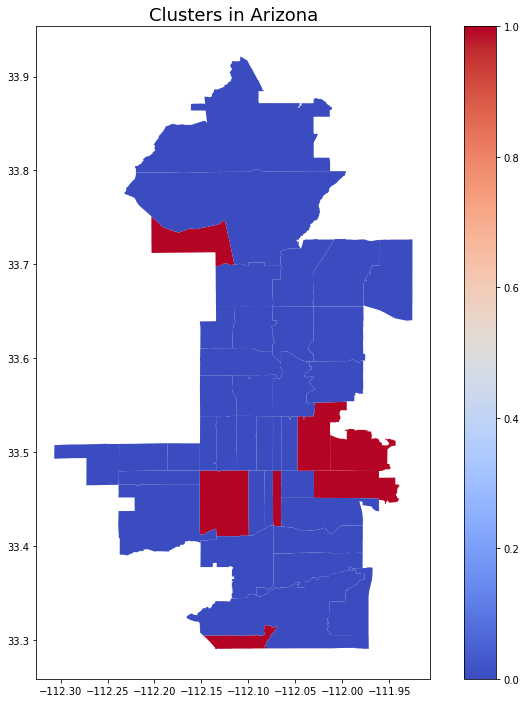

In [50]:
f, ax = plt.subplots(1, figsize=(12, 12))
ax.set_title("Clusters in Arizona", fontsize=18)
gdf.plot(axes=ax, column='labels', legend = True, cmap='coolwarm')

This result fits the expaination we made earlier.  

And let's have a look on the Phoenix City Data

In [51]:
pho = tzs.loc[tzs['PO_NAME'] == 'Phoenix']

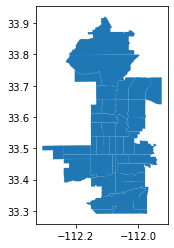

In [52]:
pho.plot()

In [53]:
len(pho)

42

It appears there are only 42 zip code in Pheonix City, so it is right not to have more numbers.

# 7. Use Folium to visualize the clusters

Create a folium map first, set up the initial point.

In [54]:
import folium
from geopy.geocoders import Nominatim
import os
import shapefile
from json import dumps

In [55]:
address = 'Phoenix City, AZ'
geolocator = Nominatim(user_agent="az_explorer")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
# Create a map 
map_phoenix = folium.Map(location=[latitude, longitude], zoom_start=10)

In [56]:
map_phoenix

Convert GeoDataFrame to GeoJSON so it could be applied in folium.

In [57]:
gdf.to_file("phoenix.geojson", driver='GeoJSON')

In [58]:
import geojson
with open("phoenix.geojson") as f:
    gj = geojson.load(f)

In [59]:
gj[0]

{"geometry": {"coordinates": [[[-112.073866, 33.480265], [-112.07387, 33.480206], [-112.073872, 33.480019], [-112.073865, 33.479969], [-112.073866, 33.479926], [-112.073866, 33.479898], [-112.073867, 33.479883], [-112.07387, 33.479741], [-112.07387, 33.479343], [-112.073873, 33.479129], [-112.073876, 33.478852], [-112.073878, 33.478435], [-112.073878, 33.478071], [-112.073884, 33.477796], [-112.073895, 33.477599], [-112.073895, 33.477483], [-112.073915, 33.476977], [-112.073919, 33.476867], [-112.073921, 33.476693], [-112.073919, 33.476639], [-112.073918, 33.476444], [-112.073912, 33.476142], [-112.073902, 33.475739], [-112.073897, 33.475598], [-112.073896, 33.475278], [-112.073898, 33.475114], [-112.0739, 33.474864], [-112.0739, 33.474518], [-112.073903, 33.474413], [-112.073915, 33.474034], [-112.073918, 33.473972], [-112.073922, 33.473881], [-112.073927, 33.473752], [-112.073932, 33.473518], [-112.073935, 33.47337], [-112.073934, 33.47318], [-112.073935, 33.473118], [-112.07393, 33.

Map the data into folium map

In [60]:
geometries = gdf['geometry'].apply(lambda x: x.wkt).values
gdf['geometry'] = geometries

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [63]:
map_phoenix.choropleth(
    geo_data=gj,
    #name='Income Tax Per Capita',
    data=gdf,
    columns=['ZIP_CODE', 'labels'],
    fill_color= 'RdBu',
    key_on='properties.ZIP_CODE',
    fill_opacity=0.9,
    line_opacity=0.3,
    
) 

In [64]:
map_phoenix# First 1.  With restaurant categories, obvious clusters, but no

Now, let's try to add labels in the map

In [65]:
lat, lon = 0, 0
longitude = []
latitude = []
i = 0
while i < len(geometries):
    new = []
    temp = geometries[i][10:-2]
    temp = temp.split(', ')
    for x in temp:
        n = x.split(' ')
        new.append(n)
    j = 0
    while j < len(new):
        new[j][0] = float(new[j][0])
        new[j][1] = float(new[j][1])
        lon += new[j][0]
        lat += new[j][1]
        j = j + 1
    lon = lon/len(new)
    lat = lat/len(new)
    longitude.append(lon)
    latitude.append(lat)
    lon = lat = 0
    i = i + 1

In [66]:
for i in range(len(gdf)):
    # Add interactive labels
    label = 'Zip Code: {0}   Cluster: {1}'.format(gdf['ZIP_CODE'].iloc[i],int(gdf['labels'].iloc[i]))
    label = folium.Popup(label, parse_html=True)
    # This is a important method
    folium.CircleMarker(
        [latitude[i], longitude[i]],
        radius=2,
        popup=label,
        color='Black',
        fill=True,
        fill_color='#000000',
        fill_opacity=0.5,
        parse_html=False).add_to(map_phoenix) 

In [67]:
map_phoenix